# and now for something completely different...

During these excersizes, we have seen a traditional parameter estimation then uncertainty analysis workflow.  We also saw for the pilot points notebooks, about 500 model runs to "calibrate" the model and then another 500 to 1000 to find a decent set (ensemble) of realizations that fit the data acceptably well.  

But...even using pilot points as a parameterization device is a form of regularization: ideally, we would have an HK parameter in every model cell. But, that is too expensive in terms of model runs for calibration and uncertainty analysis (at least as we have learned it so far).

However, there are some new techniques that free us from these computational constraints so that we can more efficiently use lots of parameters.  One approach to this is the iterative Ensemble Smoother form of the GLM.  It is implemented in pyemu and a C++ version is in the works.  Let's see how this technique works for the freyberg model - a special version of the freyberg model with an HK parameter in every cell.

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_gr()
working_dir = fs.WORKING_DIR_GR
pst_name = fs.PST_NAME_GR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_gr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_grid_ies/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVE

In [3]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
obs = pst.observation_data
obs.loc[obs.obgnme=="calhead","weight"] = 0.75
par = pst.parameter_data
hk_par = par.loc[par.pargp=="hk"].copy()
hk_par.loc[:,"i"] = hk_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
hk_par.loc[:,"j"] = hk_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
hk_par.loc[:,"x"] = m.sr.xcentergrid[hk_par.i,hk_par.j]
hk_par.loc[:,"y"] = m.sr.ycentergrid[hk_par.i,hk_par.j]
hk_par.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,i,j,x,y
parnme,,,,,,,,,,,,,,
hk_i00_j00,hk_i00_j00,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,0,125.0,9875.0
hk_i00_j01,hk_i00_j01,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,1,375.0,9875.0
hk_i00_j02,hk_i00_j02,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,2,625.0,9875.0
hk_i00_j03,hk_i00_j03,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,3,875.0,9875.0
hk_i00_j04,hk_i00_j04,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1,0,4,1125.0,9875.0


In [4]:
"number of parameters: {0} : WTF!".format(pst.npar)

'number of parameters: 814 : WTF!'

In [5]:
os.chdir(working_dir)

### First we create an ``EnsembleSmoother`` instance:

In [6]:
pst.filename = pst_name
ies = pyemu.EnsembleSmoother(pst=pst,num_slaves=15,slave_dir=".",port=4005)

``EnsembleSmoother.initialize()`` does lots of things for you:
- make draws from parcov for the initial ``ParameterEnsemble``
- make draws from obscov for the "target" ``ObservationEnsemble``
- runs the initial ``ParameterEnsemble`` forward to get the initial ``ObservationEnsemble``

In [7]:
ies.initialize(num_reals=100)

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


So what we just did was essentially an unconstrained Monte Carlo with 100 realizations - cool!

### Let's visualize the first few ``hk`` fields - drawn from prior (uncalibrated)

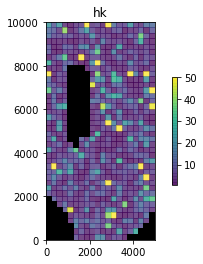

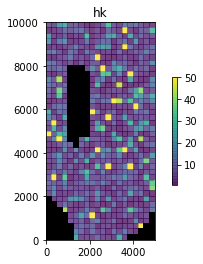

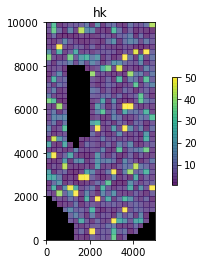

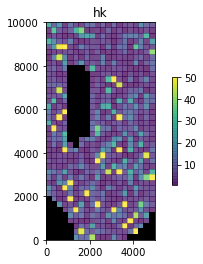

In [8]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5,colorbar=True)
    plt.show()

Those don't look very "geologic" - why? Answer: the Prior! (its always about the Prior)

### Let's visualize the distributions (histograms) for each of the forecasts

These distributions come from running the initial (uncalibrated) parameter ensemble

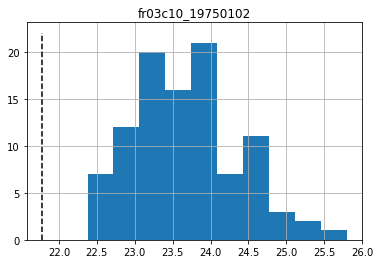

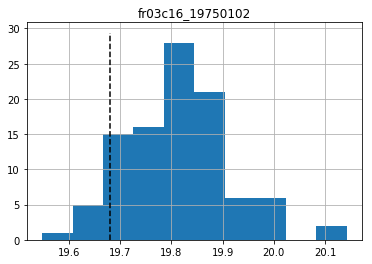

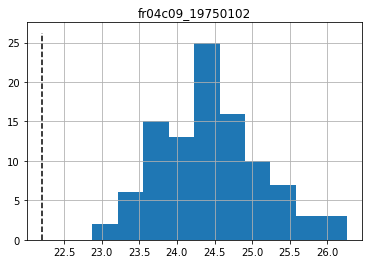

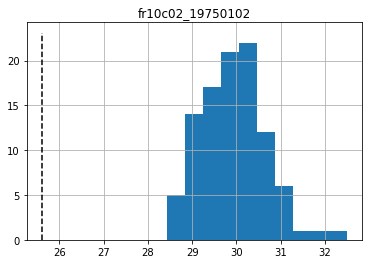

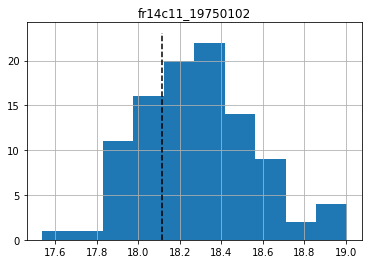

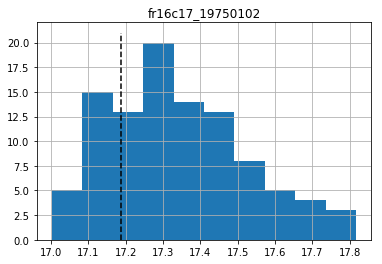

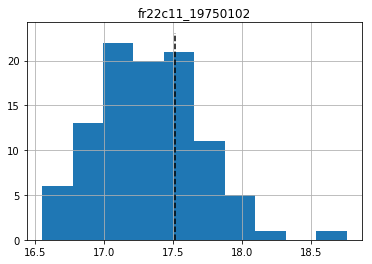

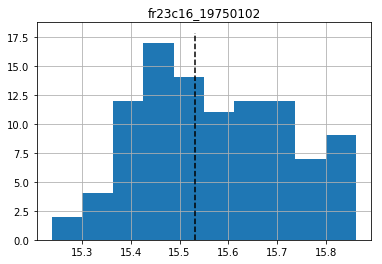

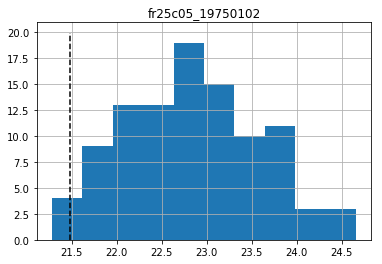

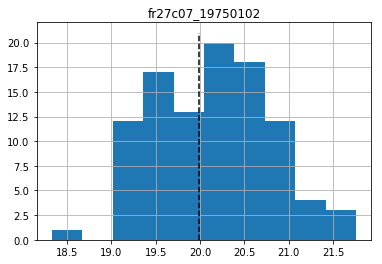

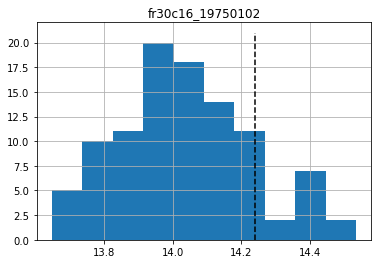

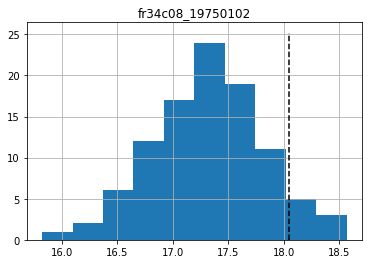

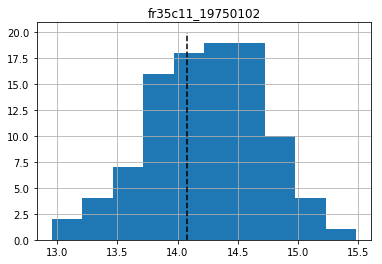

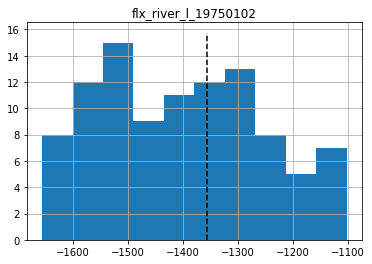

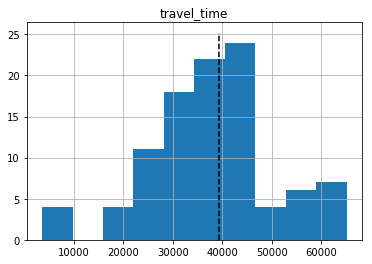

In [9]:
init_obs = ies.obsensemble.copy()
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10)
    ax.set_title(forecast)
    ylim = ax.get_ylim()
    v = ies.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--")
    plt.show()

The initial (uncalibrated) phi distribution...not so good...

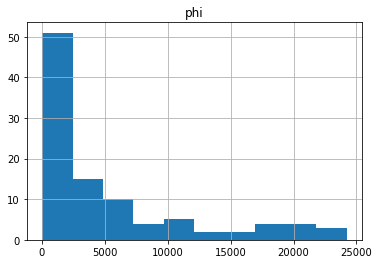

In [10]:
ies.current_phi.hist(bins=10)
plt.show()

Since we only have a few observations we are trying to match, we can look at there distributions also.  The "blue" histogram is the results of the initial parameter ensemble evaluation.  The "red" is the "target" distribution: each observation has a unique value for each realization: the observed value + a realization of measurement noise

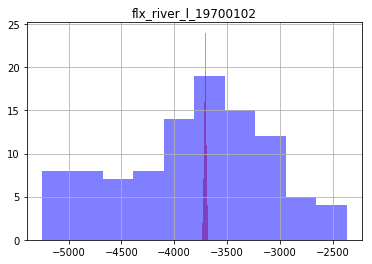

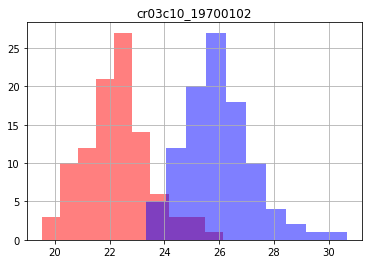

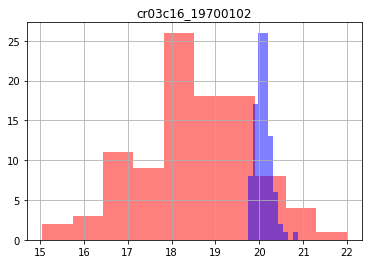

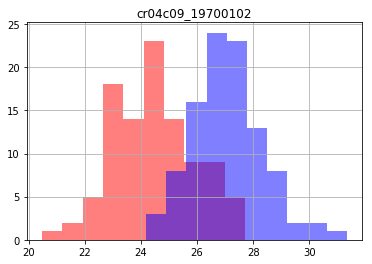

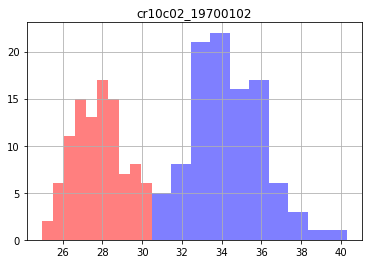

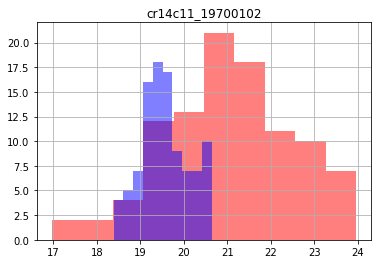

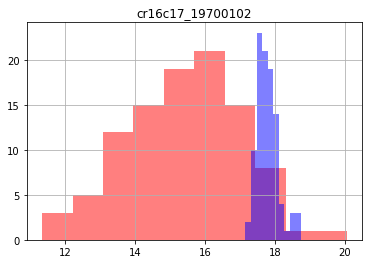

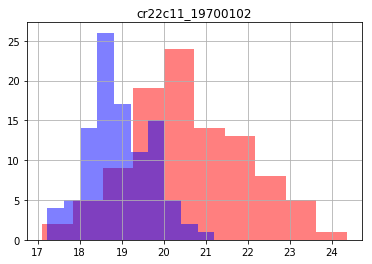

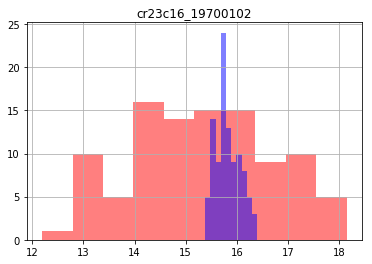

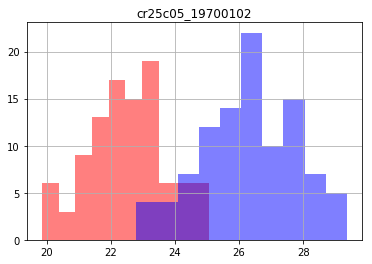

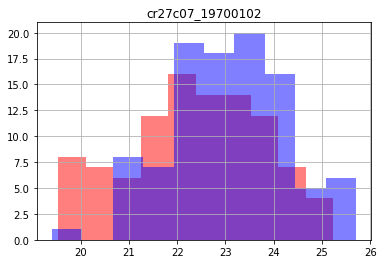

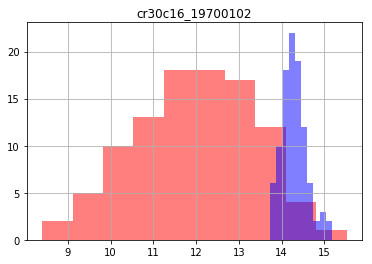

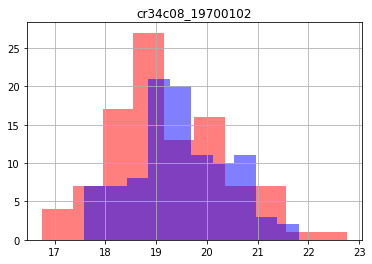

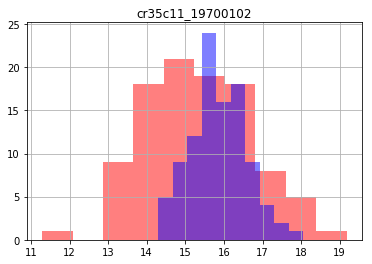

In [11]:
for oname in pst.nnz_obs_names:
    ax = ies.obsensemble_0.loc[:,oname].hist(bins=10,alpha=0.5,color='r')
    ies.obsensemble.loc[:,oname].hist(bins=10,ax=ax,alpha=0.5,color='b')
    ax.set_title(oname)
    plt.show()

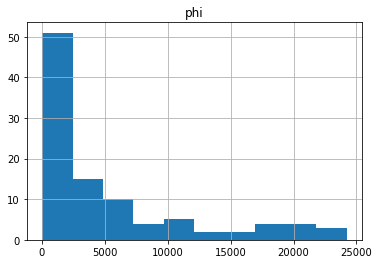

phi    39.122974
dtype: float64

In [12]:
ies.current_phi.hist()
plt.show()
ies.current_phi.min()

There's quite a spread on phi values - some really good, some really really bad....

``EnsembleSmoother.update()`` propagates the ensemble forward, updating the ``ParameterEnsemble`` through the GLM algorithm, then runs the new ``ParameterEnsemble``.  In other words, we are going to use an approximate (low fidelity) Jacobian to update the entire parameter ensemble, the we are going to run another Monte Carlo

In [13]:
ies.update()

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


Let's see how phi is doing...

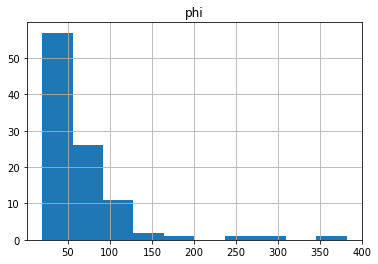

phi    19.335672
dtype: float64

In [14]:
ies.current_phi.hist(bins=10)
plt.show()
ies.current_phi.mean()

Notice how much the ``phi`` distribution has decreased compared to the initialized ``EnsembleSmoother``: Nice!

Now let's run through a few more updates...and plot the phi distribution each time

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


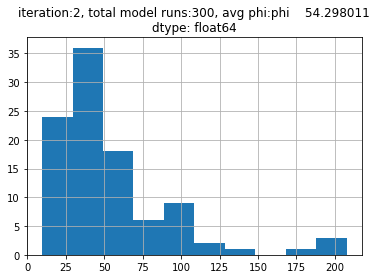

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


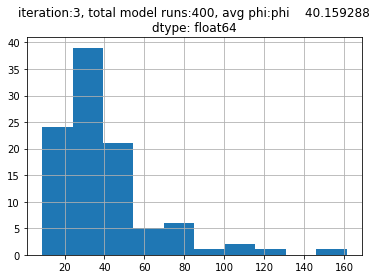

In [15]:
for i in range(2):
    ies.update()
    phi = ies.current_phi
    ax = plt.subplot(111)
    phi.hist(bins=10,ax=ax)
    ax.set_title("iteration:{0}, total model runs:{1}, avg phi:{2}".format(ies.iter_num,ies.total_runs,phi.mean()))
    plt.show()

Wow!  phi has gotten really good after only a 400ish runs of the model - remember, there over 700 parameters. Let's see how the forecasts are doing...

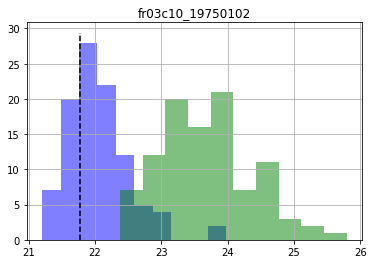

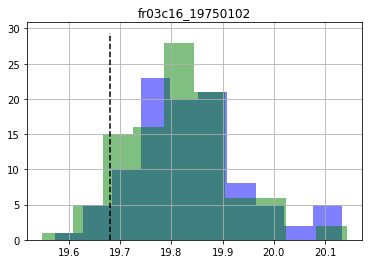

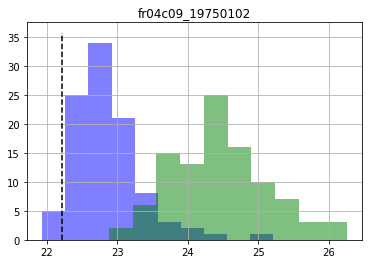

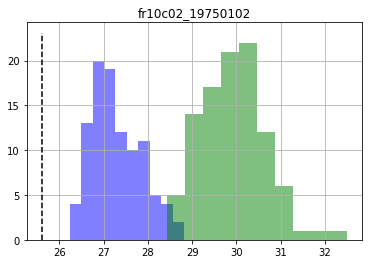

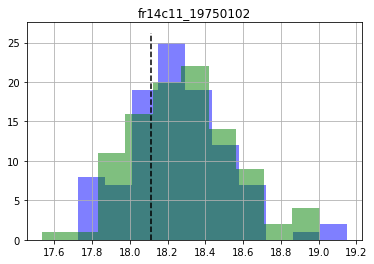

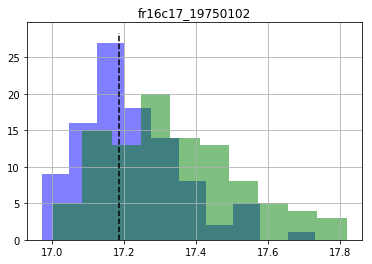

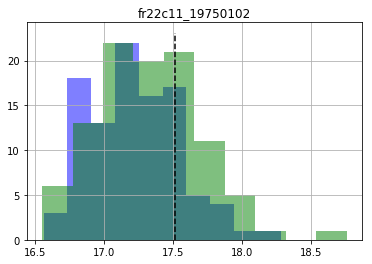

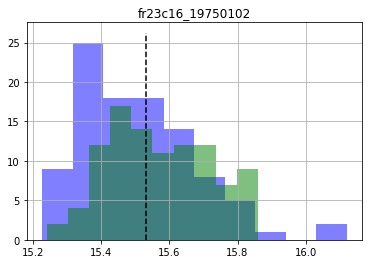

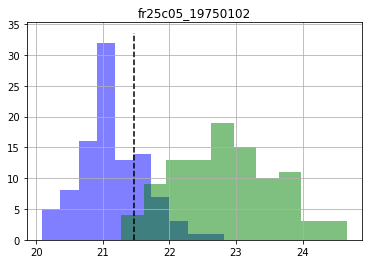

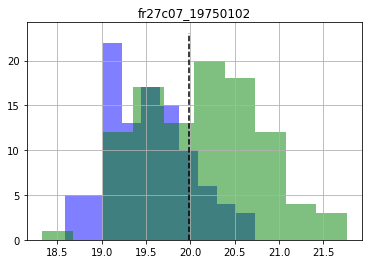

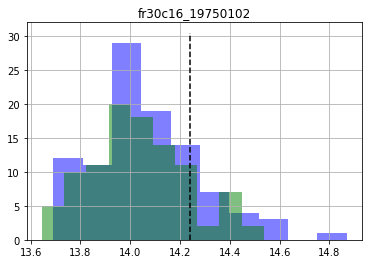

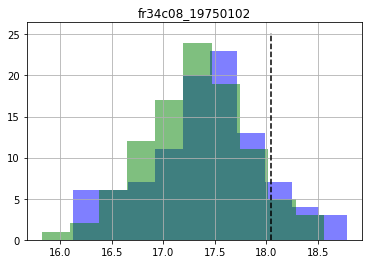

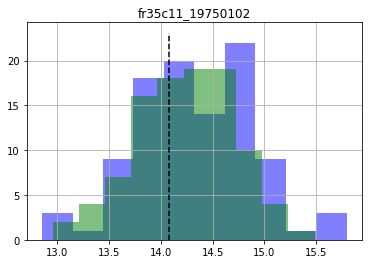

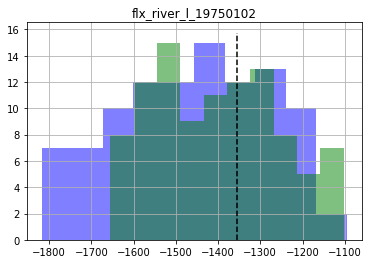

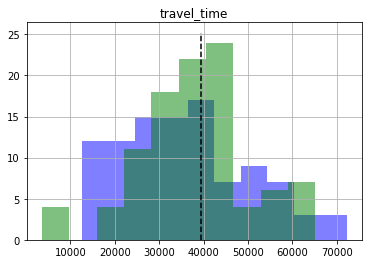

In [16]:
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10,color='b',alpha=0.5)
    init_obs.loc[:,forecast].hist(bins=10,ax=ax,color='g',alpha=0.5)
    ax.set_title(forecast)
    ylim = ax.get_ylim()
    v = ies.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--")
    plt.show()

In [17]:
ies.total_runs

400

In [18]:
df_sum = pd.read_csv(pst_name+".iobj.csv")
df_sum

,iter_num,total_runs,lambda,min,max,mean,median,std,0000000001,0000000002,...,0000000091,0000000092,0000000093,0000000094,0000000095,0000000096,0000000097,0000000098,0000000099,0000000100
0,0,100,0.00000,39.122974,24209.647656,5212.826257,2127.683868830669 8552.7558,4426.926100,99.420330,6793.231500,...,4898.754000,501.898580,1181.150300,150.690350,275.157000,21208.921000,18044.279000,17284.984000,NaN,NaN
1,1,200,0.10000,19.335672,381.613292,66.046024,49.61407648043375 57.047854,32.880086,60.171747,98.287214,...,104.590180,92.373901,37.509459,35.985004,381.613290,262.111110,54.708426,45.331284,NaN,NaN
2,2,300,0.07500,9.748105,207.525180,54.298011,41.2843131753374 31.524289,29.527894,57.737301,133.429000,...,72.397777,31.510003,31.569915,29.018765,105.027710,32.432857,68.742713,48.100714,NaN,NaN
3,3,400,0.05625,8.799578,161.282448,40.159288,32.967339273740635 75.67008,27.962711,64.474634,49.890755,...,37.967314,26.226507,23.202337,33.027978,34.871758,74.022912,44.816315,49.943578,NaN,NaN


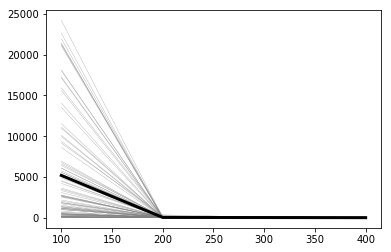

In [19]:
ax = plt.subplot(111)
real_cols = [c for c in df_sum.columns if c.startswith("0")]
[ax.plot(df_sum.total_runs,df_sum.loc[:,rc],'0.5',lw=0.25) for rc in real_cols]
ax.plot(df_sum.total_runs,df_sum.loc[:,"mean"],"k",lw=3)
plt.show()

Awesome!  We are crushing phi...but how to the parameter fields looks?

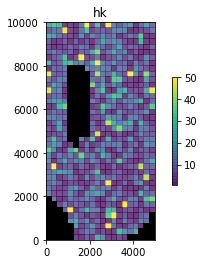

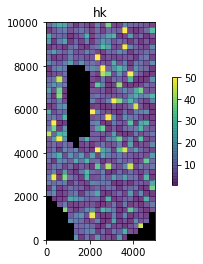

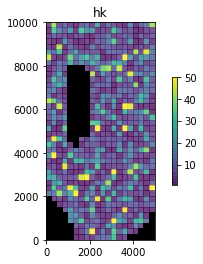

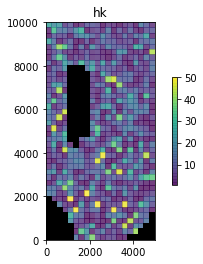

In [20]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5,colorbar=True)
    plt.show()

Uh oh. The fields look like noise...how can we fix this? Solution: a full covariance matrix that expresses spatial correlation

### iES with a full covariance matrix

Now let's rerun the iES process but with a full, geostatistical prior covariance matrix

In [21]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)

In [22]:
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={gs:[hk_par]},sigma_range=6)

Let's see how this covariance looks compare to the one we used previously

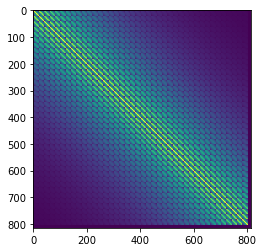

In [23]:
plt.imshow(cov.x)

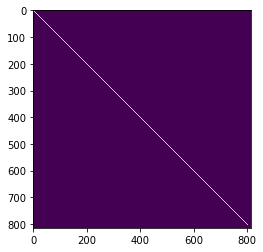

In [24]:
plt.imshow(ies.parcov.as_2d)

Now we create a new ``iES`` and update 3 times...

In [25]:
ies = pyemu.EnsembleSmoother(pst=pst,num_slaves=15,slave_dir=".",parcov=cov,port=4005)
ies.initialize(num_reals=100)

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


Let's visual the new parameter fields:

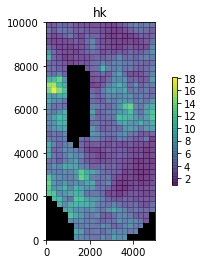

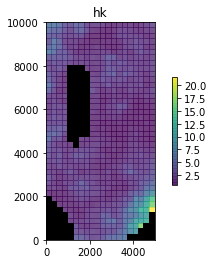

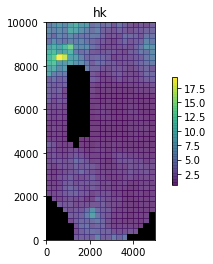

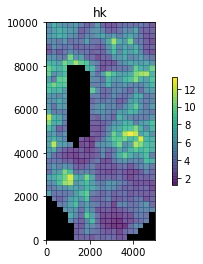

In [26]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5,colorbar=True)
    plt.show()

Those fields look much more "geologic" (what ever that means)...let's see how well the smoother does with these fields

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


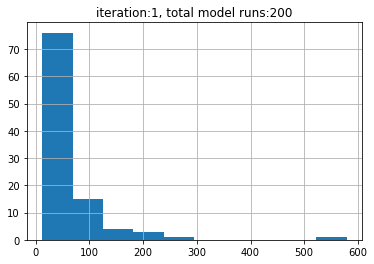

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


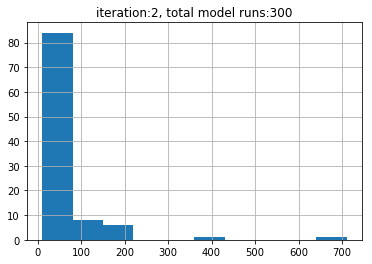

run():./sweep freyberg_gr.pst /h :4005 1>_master_stdout.dat 2>_master_stderr.dat
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_0
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_1
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_2
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_3
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_4
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_5
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_6
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_7
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_8
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_9
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_10
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_11
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_12
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_13
slave:sweep freyberg_gr.pst /h localhost:4005 in ../slave_14


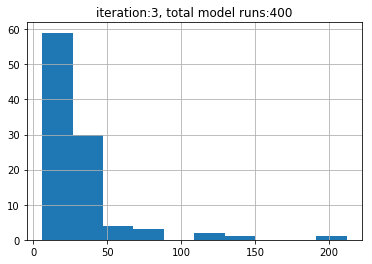

In [27]:
for _ in range(3):
    ies.update()
    phi = ies.current_phi
    ax = plt.subplot(111)
    phi.hist(bins=10,ax=ax)
    ax.set_title("iteration:{0}, total model runs:{1}".format(ies.iter_num,ies.total_runs))
    plt.show()

phi looks really good still...let's see how the final (calibrated) parameter fields look....

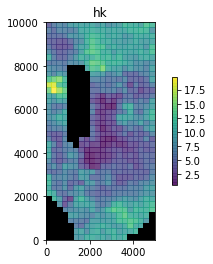

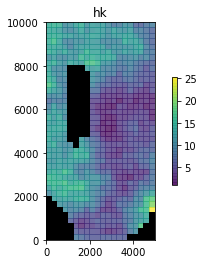

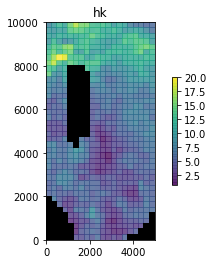

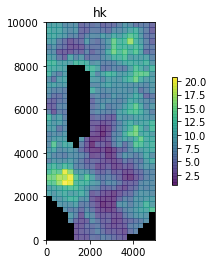

In [28]:
for real in ies.parensemble.index[:4]:
    arr = np.zeros((m.nrow,m.ncol))
    arr[hk_par.i,hk_par.j] = ies.parensemble.loc[real,hk_par.parnme]
    m.upw.hk[0] = arr
    m.upw.hk[0].plot(alpha=0.5,colorbar=True)
    plt.show()

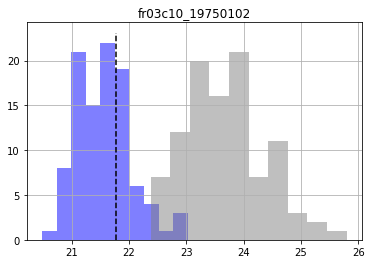

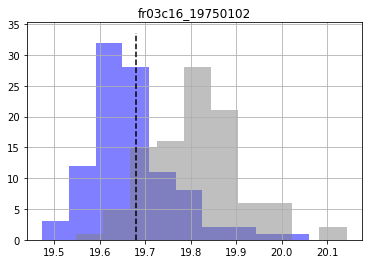

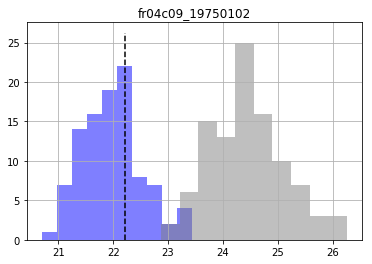

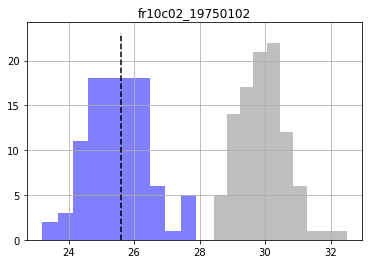

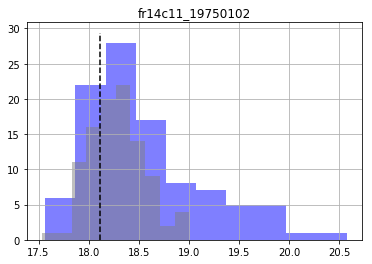

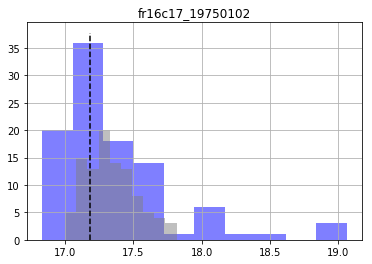

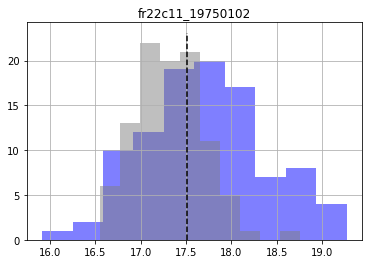

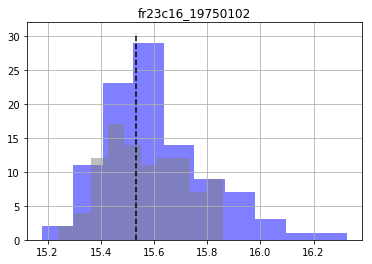

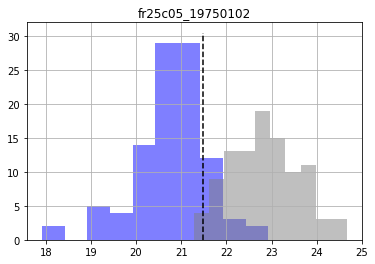

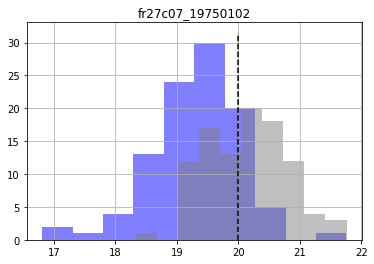

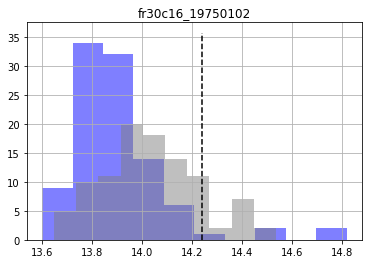

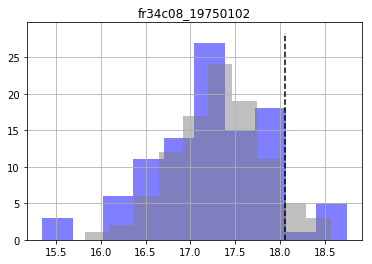

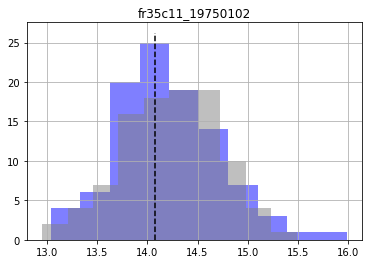

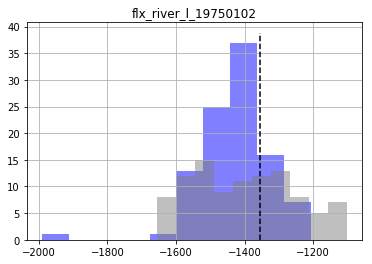

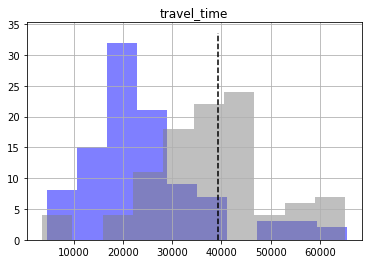

In [29]:
for forecast in pst.forecast_names:
    ax = ies.obsensemble.loc[:,forecast].hist(bins=10,color='b',alpha=0.5,label="posterior")
    init_obs.loc[:,forecast].hist(bins=10,color="0.5",alpha=0.5,label="prior")
    ax.set_title(forecast)
    ylim = ax.get_ylim()
    v = ies.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--")
    plt.show()

We see that the final (posterior) ensemble is bracketing the "truth" for all forecasts...yeah! 